In [ ]:
# 安装数据集可视化所需包
!pip install pycocotools
!pip install scikit-image

# 1 数据集信息
## 1.1 数据集的准备与介绍

### **数据集介绍**

数据集包含多个损坏零件的汽车图像，来源于AI Studio提供的公共数据集，进一步源自于Kaggle的汽车损坏数据集。该数据集属于交通领域，适合计算机视觉中目标检测或实例分割任务。

数据集共有78张图片，以jpg格式存储，位于img文件夹中。

按数据集提供者的数据集分割，train、val、test各包括59、11和8张图片，每张图片以jpg格式存储。其中，train和val包含COCO格式的注释文件。

数据集提供COCO格式的注释，分为两个类型。一部分是仅描述了损坏发生的位置，即仅有damage一类目标；另一部分则描述了损坏具体发生的位置，共有headlamp、front_bumper、hood、door、rear_bumper五类。


In [ ]:
# 解压数据集
%cd /home/aistudio/
!unzip -oq /home/aistudio/data/data105047/archive\ \(1\).zip -d data/dataset/

/home/aistudio


In [ ]:
# 查看数据集的目录结构
!tree data/dataset/ -d

data/dataset/
├── img
├── test
├── train
└── val

4 directories


In [ ]:
# 数据集可视化显示
import json
import os
import cv2
from pycocotools.coco import COCO
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.font_manager  # 解决字体问题

train_path = 'data/dataset/train/'
train_json = train_path + 'COCO_train_annos.json'

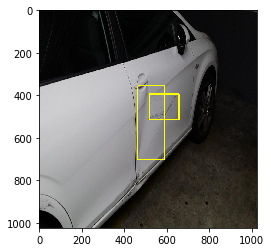

In [ ]:
# 可视化bounding box
def visualization_bbox(num_image, json_path, img_path):
    with open(json_path) as annos:
        annotation_json = json.load(annos)

    # 读取图片名
    image_name = annotation_json['images'][num_image - 1]['file_name']  # 读取图片名
    # 读取图片id
    image_id = annotation_json['images'][num_image - 1]['id']  # 读取图片id

    image_path = os.path.join(img_path, str(image_name).zfill(5))
    image = cv2.imread(image_path, 1)

    for i in range(len(annotation_json['annotations'][::])):
        if annotation_json['annotations'][i - 1]['image_id'] == image_id:
            x, y, w, h = annotation_json['annotations'][i - 1]['bbox']  # 读取边框
            image = cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 255), 4)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

visualization_bbox(5, train_json, train_path)  # 第一个参数表示指定可视化某张图片

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


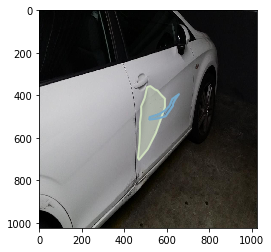

In [ ]:
# 可视化分割效果
def visualization_seg(num_image, json_path):
    coco = COCO(json_path)

    catIds = coco.getCatIds(catNms=[""])
    imgIds = coco.getImgIds(catIds=catIds)
    img = coco.loadImgs(imgIds[num_image - 1])[0]
    image = io.imread(train_path + img['file_name'])

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    plt.imshow(image)
    coco.showAnns(anns)
    plt.show()

visualization_seg(5, train_json)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


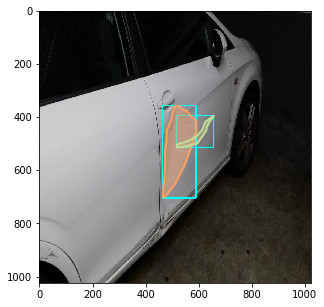

In [ ]:
# 同时可视化分割效果和bounding box
def visualization_both(num_image, json_path, img_path):
    coco = COCO(json_path)
    catIds = coco.getCatIds(catNms=[""])

    list_imgIds = coco.getImgIds(catIds=catIds)
    img = coco.loadImgs(list_imgIds[num_image-1])[0]
    image = io.imread(img_path + img['file_name'])

    img_annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    img_anns = coco.loadAnns(img_annIds)

    for i in range(len(img_annIds)):
        x, y, w, h = img_anns[i-1]['bbox']
        image = cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 255), 4)

    plt.rcParams['figure.figsize'] = (5.0, 5.0)
    plt.imshow(image)
    coco.showAnns(img_anns)
    plt.show()

visualization_both(5, train_json, train_path)


## 1.2图像数据统计分析

In [ ]:
# 计算数据集图像均值和方差

import glob
import numpy as np
import cv2


def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std

path1 = 'data/dataset/img/'
path2 = 'data/dataset/test/'
img_list = glob.glob(path1 + "*.jpg") + glob.glob(path2 + '*.jpg')
mean, std = get_mean_std(img_list)
print('mean:', mean)
print('std:', std)

Total images: 78
mean: [0.4119028  0.41137671 0.413536  ]
std: [0.25194435 0.25286561 0.25082428]


## 1.3数据集类的定义

这里整体思路是通过COCO格式的annotation文件读取数据集信息。

初始化数据集时，读取annotation文件，而test不含annotation文件。

getitem方法，从annotation中按idx选取图片，以plt的方式读入，并在annotation文件的'annotations'中获取对应idx图片的label信息。这里实现了两个功能，既可以返回用于目标检测的四维bounding box坐标，也可以返回用于实例分割的分割点数据。

len方法，可以直接读取annotation文件中'images'包含的图片数得到，若test则通过glob统计。

In [ ]:
from paddle.io import Dataset
from matplotlib import pyplot as plt
import json
import glob


DATASET_PATH = 'data/dataset/{}/'
ANNO_FILE = 'COCO_{}_annos.json'


class CustomDataset(Dataset):

    def __init__(self, mode='train', application='detection'):
        super(CustomDataset, self).__init__()
        assert mode.lower() in ['train', 'val', 'test'], \
            "mode should be 'train', 'val' or 'test', but got {}".format(mode)
        assert application.lower() in ['detection', 'segmentation'], \
            "application should be 'detection' or 'segmentation', but got {}".format(application)

        self.application = application
        self.mode = mode
        if self.mode != 'test':
            self.annotation = self._load_anno(self.mode)
        else:
            self.annotation = None

    def _load_anno(self, mode):
        annotation_path = DATASET_PATH.format(mode) + ANNO_FILE.format(mode)
        with open(annotation_path) as annos:
            annotation_json = json.load(annos)
        return annotation_json

    def __getitem__(self, idx):
        assert self.mode.lower() in ['train', 'val'], \
            "mode should be 'train' or 'val', but got {}".format(self.mode)

        # 返回matplotlib打开的图片格式
        img_name = self.annotation['images'][idx]['file_name']
        img_path = DATASET_PATH.format(self.mode) + img_name
        data = plt.imread(img_path)

        label = []
        if self.application == 'detection':
            for i in range(len(self.annotation['annotations'][::])):
                if self.annotation['annotations'][i - 1]['image_id'] == idx:
                    label.append(self.annotation['annotations'][i - 1]['bbox'])
        if self.application == 'segmentation':
            for i in range(len(self.annotation['annotations'][::])):
                if self.annotation['annotations'][i - 1]['image_id'] == idx:
                    label.append(self.annotation['annotations'][i - 1]['segmentation'][0])

        return data, label

    def __len__(self):
        if self.mode == 'test':
            return len(glob.glob(DATASET_PATH.format('test') + '*.jpg'))
        return len(self.annotation['images'])

## 1.4数据集类的测试

In [ ]:
# 测试各文件夹中用于目标检测和实例分割的len方法
d1 = CustomDataset(mode='train', application='detection')
d2 = CustomDataset(mode='val', application='detection')
d3 = CustomDataset(mode='test', application='detection')
d4 = CustomDataset(mode='train', application='segmentation')
d5 = CustomDataset(mode='val', application='segmentation')
d6 = CustomDataset(mode='test', application='segmentation')

print('train 文件夹 目标检测 ' + str(len(d1)))
print('val   文件夹 目标检测 ' + str(len(d2)))
print('test  文件夹 目标检测 ' + str(len(d3)))
print('train 文件夹 实例分割 ' + str(len(d4)))
print('val   文件夹 实例分割 ' + str(len(d5)))
print('test  文件夹 实例分割 ' + str(len(d6)))

train 文件夹 目标检测 59
val   文件夹 目标检测 11
test  文件夹 目标检测 8
train 文件夹 实例分割 59
val   文件夹 实例分割 11
test  文件夹 实例分割 8


In [ ]:
# 这里就不详细每个都测试了，测试train文件夹下某张图片用于实例分割和目标检测的getitem方法

data, label = d1[4]
print('目标检测')
print(data.shape)
print(label)
print()
data, label = d4[5]
print('实例分割')
print(data.shape)
print(label)

目标检测
(1024, 1024, 3)
[[464, 356, 127, 347], [518, 394, 139, 120]]

实例分割
(1024, 1024, 3)
[[377, 481, 391, 478, 406, 453, 429, 471, 441, 488, 488, 494, 530, 523, 563, 560, 608, 588, 630, 609, 574, 618, 575, 645, 586, 664, 583, 676, 561, 693, 521, 693, 487, 683, 457, 655, 429, 638, 411, 638, 410, 609, 387, 607, 377, 584, 345, 567, 304, 552, 281, 538, 243, 516, 243, 492, 292, 509, 331, 513, 348, 494, 364, 486], [498, 703, 520, 703, 549, 714, 578, 724, 583, 734, 578, 747, 565, 747, 542, 745, 517, 735, 509, 728, 499, 718]]


In [ ]:
# 使用train_dataloader测试
import paddle

d = CustomDataset(mode='train', application='detection')

train_dataloader = paddle.io.DataLoader(
    d,
    batch_size=1,
    shuffle=True,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, len(label))

0 [1, 1024, 1024, 3] 1
1 [1, 1024, 1024, 3] 1
2 [1, 1024, 1024, 3] 1
3 [1, 1024, 1024, 3] 1
4 [1, 1024, 1024, 3] 2
5 [1, 1024, 1024, 3] 1
6 [1, 1024, 1024, 3] 3
7 [1, 1024, 1024, 3] 1
8 [1, 1024, 1024, 3] 1
9 [1, 1024, 1024, 3] 3
10 [1, 1024, 1024, 3] 10
11 [1, 1024, 1024, 3] 1
12 [1, 1024, 1024, 3] 2
13 [1, 1024, 1024, 3] 1
14 [1, 1024, 1024, 3] 1
15 [1, 1024, 1024, 3] 2
16 [1, 1024, 1024, 3] 2
17 [1, 1024, 1024, 3] 3
18 [1, 1024, 1024, 3] 1
19 [1, 1024, 1024, 3] 3
20 [1, 1024, 1024, 3] 1
21 [1, 1024, 1024, 3] 1
22 [1, 1024, 1024, 3] 4
23 [1, 1024, 1024, 3] 2
24 [1, 1024, 1024, 3] 1
25 [1, 1024, 1024, 3] 1
26 [1, 1024, 1024, 3] 2
27 [1, 1024, 1024, 3] 2
28 [1, 1024, 1024, 3] 7
29 [1, 1024, 1024, 3] 6
30 [1, 1024, 1024, 3] 2
31 [1, 1024, 1024, 3] 1
32 [1, 1024, 1024, 3] 1
33 [1, 1024, 1024, 3] 3
34 [1, 1024, 1024, 3] 3
35 [1, 1024, 1024, 3] 1
36 [1, 1024, 1024, 3] 4
37 [1, 1024, 1024, 3] 1
38 [1, 1024, 1024, 3] 2
39 [1, 1024, 1024, 3] 1
40 [1, 1024, 1024, 3] 6
41 [1, 1024, 1024, 3] 5
4

# 2 安装PaddleDetection

使用PaddleDetection中的PicoDet模型完成车损检测的任务。

由于PaddleDetection项目较大，因此在外部下载PaddleDetection的压缩包，上传到文件中，然后直接解压使用。

In [ ]:
# 解压PaddleDetection
%cd work/
!unzip -oq /home/aistudio/work/PaddleDetection.zip

/home/aistudio/work


In [ ]:
# 移动到根目录下
!mv /home/aistudio/work/PaddleDetection /home/aistudio/

In [1]:
# 每次打开notebook需要重新执行的文件：
# 解压数据集，每次打开notebook重新执行
%cd /home/aistudio/
!unzip -oq /home/aistudio/data/data105047/archive\ \(1\).zip -d data/dataset/

# 安装，每次打开notebook重新执行
%cd PaddleDetection/
!pip install -r requirements.txt
!python setup.py install
%cd /home/aistudio/PaddleDetection/


# 3 修改配置文件

picodet模型主要用到六个相关的配置文件，对其内容做更改，用于对车损检测任务训练

## 3.1 coco_detection.yml
该配置文件记录了数据集的路径和内容等信息。
因为进行车损检测的的任务，所检测的目标仅有一种，因此修改num_classes为1。分别修改train、val、test三个数据集的annotation文件位置和数据集的文件位置，以正确读取数据集的相关信息。
```
metric: COCO
num_classes: 1

TrainDataset:
  !COCODataSet
    image_dir:
    anno_path: COCO_train_annos.json
    dataset_dir: ../data/dataset/train
    data_fields: ['image', 'gt_bbox', 'gt_class']

EvalDataset:
  !COCODataSet
    image_dir:
    anno_path: COCO_val_annos.json
    dataset_dir: ../data/dataset/val

TestDataset:
  !ImageFolder
    image_dir: data/test
    anno_path: COCO_val_annos.json
    dataset_dir: ../data/dataset/val
```
## 3.2 runtime.yml

该配置文件记录了有关训练的相关信息，包括使用的硬件、记录次数等。
此部分内容暂无需修改。
```
use_gpu: true
use_xpu: false
log_iter: 20
save_dir: output
snapshot_epoch: 1
print_flops: false
```
## 3.3 picodet_esnet.yml

该配置文件记录了有关picodet的backbone所使用的的ESNet的相关参数设置。

为了方便模型的运行，将预训练权重修改为使用相同模型在COCO数据集上的预训练模型进行。
```
architecture: PicoDet
pretrain_weights: weights/picodet_l_640_coco.pdparams

PicoDet:
  backbone: ESNet
  neck: CSPPAN
  head: PicoHead

ESNet:
  scale: 1.0
  feature_maps: [4, 11, 14]
  act: hard_swish
  channel_ratio: [0.875, 0.5, 1.0, 0.625, 0.5, 0.75, 0.625, 0.625, 0.5, 0.625, 1.0, 0.625, 0.75]

CSPPAN:
  out_channels: 128
  use_depthwise: True
  num_csp_blocks: 1
  num_features: 4

PicoHead:
  conv_feat:
    name: PicoFeat
    feat_in: 128
    feat_out: 128
    num_convs: 4
    num_fpn_stride: 4
    norm_type: bn
    share_cls_reg: True
  fpn_stride: [8, 16, 32, 64]
  feat_in_chan: 128
  prior_prob: 0.01
  reg_max: 7
  cell_offset: 0.5
  loss_class:
    name: VarifocalLoss
    use_sigmoid: True
    iou_weighted: True
    loss_weight: 1.0
  loss_dfl:
    name: DistributionFocalLoss
    loss_weight: 0.25
  loss_bbox:
    name: GIoULoss
    loss_weight: 2.0
  assigner:
    name: SimOTAAssigner
    candidate_topk: 10
    iou_weight: 6
  nms:
    name: MultiClassNMS
    nms_top_k: 1000
    keep_top_k: 100
    score_threshold: 0.025
    nms_threshold: 0.6

```

## 3.4 optimizer_300e.yml

该配置文件记录了有关学习率和优化器相关的参数配置。

由于原学习率0.3为在多卡环境下训练的设置，我们仅在单卡训练，且batch尺寸约为默认尺寸的一半，因此设为0.04。
```
epoch: 70

LearningRate:
  base_lr: 0.04
  schedulers:
  - !CosineDecay
    max_epochs: 300
  - !LinearWarmup
    start_factor: 0.1
    steps: 300

OptimizerBuilder:
  optimizer:
    momentum: 0.9
    type: Momentum
  regularizer:
    factor: 0.00004
    type: L2
```

## 3.5 picodet_640_reader.yml

该配置文件记录了数据读取相关的参数配置。
根据显卡显存情况，因此可以将batch设置为数据集的一半图片，即30，读取线程(num_workers)设为3。将数据集的均值和方差按此前计算的值进行替换。
```
worker_num: 3
TrainReader:
  sample_transforms:
  - Decode: {}
  - RandomCrop: {}
  - RandomFlip: {prob: 0.5}
  - RandomDistort: {}
  batch_transforms:
  - BatchRandomResize: {target_size: [576, 608, 640, 672, 704], random_size: True, random_interp: True, keep_ratio: False}
  - NormalizeImage: {is_scale: true, mean: [0.412,0.411,0.414], std: [0.252,0.253,0.251]}
  - Permute: {}
  batch_size: 30
  shuffle: true
  drop_last: false
  collate_batch: false


EvalReader:
  sample_transforms:
  - Decode: {}
  - Resize: {interp: 2, target_size: [640, 640], keep_ratio: False}
  - NormalizeImage: {is_scale: true, mean: [0.412,0.411,0.414], std: [0.252,0.253,0.251]}
  - Permute: {}
  batch_transforms:
  - PadBatch: {pad_to_stride: 32}
  batch_size: 11
  shuffle: false


TestReader:
  inputs_def:
    image_shape: [1, 3, 640, 640]
  sample_transforms:
  - Decode: {}
  - Resize: {interp: 2, target_size: [640, 640], keep_ratio: False}
  - NormalizeImage: {is_scale: true, mean: [0.412,0.411,0.414], std: [0.252,0.253,0.251]}
  - Permute: {}
  batch_transforms:
  - PadBatch: {pad_to_stride: 32}
  batch_size: 1
  shuffle: false
```
## 3.6 picodet_l_640_coco.yml

该配置文件为最主要的配置文件，记录了其他几个配置文件的位置，以及相关重要的参数设置，这里的参数其实与记录的几个配置文件相同，但优先按该文件的设置，因此将之前五个文件中的设置在该文件中再次修改或直接删除即可。
```
_BASE_: [
  '../datasets/coco_detection.yml',
  '../runtime.yml',
  '_base_/picodet_esnet.yml',
  '_base_/optimizer_300e.yml',
  '_base_/picodet_640_reader.yml',
]

weights: output/picodet_l_640_coco/model_final
find_unused_parameters: True
use_ema: true
cycle_epoch: 40
snapshot_epoch: 10

ESNet:
  scale: 1.25
  feature_maps: [4, 11, 14]
  act: hard_swish
  channel_ratio: [0.875, 0.5, 1.0, 0.625, 0.5, 0.75, 0.625, 0.625, 0.5, 0.625, 1.0, 0.625, 0.75]

CSPPAN:
  out_channels: 160

PicoHead:
  conv_feat:
    name: PicoFeat
    feat_in: 160
    feat_out: 160
    num_convs: 4
    num_fpn_stride: 4
    norm_type: bn
    share_cls_reg: True
  feat_in_chan: 160
```



# 4 模型训练

按上述配置文件进行模型训练，采用边训练边验证的模式，并且记录log文件，可以用于后续的loss和ap曲线的绘制。

In [20]:
# 训练
!python tools/train.py -c configs/picodet/picodet_l_640_coco.yml --eval --use_vdl=true --vdl_log_dir=vdl_dir/scalar

# 5 模型评估

对训练模型进行评估，mAP约为19.2。

In [21]:
# 评估
!python tools/eval.py -c configs/picodet/picodet_l_640_coco.yml -o weights=output/model_final.pdparams

W0221 21:22:57.100888 18271 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0221 21:22:57.106287 18271 device_context.cc:465] device: 0, cuDNN Version: 7.6.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[02/21 21:23:00] ppdet.utils.checkpoint INFO: Finish loading model weights: output/model_final.pdparams
[02/21 21:23:01] ppdet.engine INFO: Eval iter: 0
[02/21 21:23:01] ppdet.metrics.metrics INFO: The bbox result is saved to bbox.json.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[02/21 21:23:01] ppdet.metrics.coco_utils INFO: Start evaluate...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 

# 6 模型导出

为了使用训练好的模型进行推理，将模型进行导出，可以用于进一步部署使用。

In [3]:
# 模型导出
!python tools/export_model.py -c configs/picodet/picodet_l_640_coco.yml \
    -o weights=output/model_final.pdparams --output_dir=inference_model

[02/22 00:19:09] ppdet.utils.checkpoint INFO: Finish loading model weights: output/model_final.pdparams
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[02/22 00:19:09] ppdet.engine INFO: Export inference config file to inference_model/picodet_l_640_coco/infer_cfg.yml
W0222 00:19:13.964409   461 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0222 00:19:13.964483   461 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/22 00:19:17] ppdet.engine INFO: Export model and saved in inference_model/picodet_l_640_coco


# 7 模型推理

从测试集中选取某张图片进行推理测试。

In [10]:
# 推理
!python tools/infer.py -c configs/picodet/picodet_l_640_coco.yml \
    -o weights=output/model_final.pdparams \
    --infer_img=/home/aistudio/data/dataset/test/66.jpg --output_dir infer_output/

W0222 00:27:36.604212  1060 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0222 00:27:36.609527  1060 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/22 00:27:39] ppdet.utils.checkpoint INFO: Finish loading model weights: output/model_final.pdparams
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[02/22 00:27:39] ppdet.engine INFO: Detection bbox results save in infer_output/66.jpg


推理的图片保存于PaddleDetection/infer_output/目录下，对该推理图片可视化。

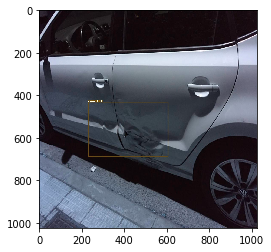

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread("infer_output/66.jpg")

plt.imshow(img)
plt.show()

可以看到，图片中的车损位置被成功检出，但置信度不高，仅有0.3。